In [67]:
!nvidia-smi 

Sun Aug  8 12:55:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    35W / 250W |   4637MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [68]:
!wget https://raw.githubusercontent.com/Balagopal-datascientist/cnn_tensorflow_food/master/helper_functions.py

--2021-08-08 12:55:40--  https://raw.githubusercontent.com/Balagopal-datascientist/cnn_tensorflow_food/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-08 12:55:40 (51.1 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [69]:
from helper_functions import create_tensorboard_callback,plot_loss_curves, unzip_data, compare_historys, walk_through_dir


In [70]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-08-08 12:55:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   260MB/s    in 6.0s    

2021-08-08 12:55:47 (259 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [71]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fish_and_chips'.
There are 0 directories and 75 images in '101_food_c

In [72]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [73]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomZoom(0.2)
], name = "data_augmentation")

In [74]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
inputs = layers.Input(shape=(224,224,3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output')(x)
model = tf.keras.Model(inputs,outputs)


In [75]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [76]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [77]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#model checkpoint 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = 'epoch',
                                                         verbose = 1)

In [78]:
hist = model.fit(train_data_all_10_percent,
          epochs = 5,
          validation_data = test_data,
          validation_steps = len(test_data),
          callbacks = [checkpoint_callback]) 

Epoch 1/5
237/237 [==============================] - 91s 356ms/step - loss: 3.4778 - accuracy: 0.2454 - val_loss: 2.4442 - val_accuracy: 0.4486

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
237/237 [==============================] - 82s 345ms/step - loss: 2.3586 - accuracy: 0.4554 - val_loss: 2.0194 - val_accuracy: 0.5059

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
237/237 [==============================] - 81s 343ms/step - loss: 1.9750 - accuracy: 0.5337 - val_loss: 1.8571 - val_accuracy: 0.5297

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
237/237 [==============================] - 81s 343ms/step - loss: 1.7590 - accuracy: 0.5728 - val_loss: 1.7750 - val_accuracy: 0.5398

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
237/237 [==============================] - 81s 343ms/step - loss: 1.6020 - acc

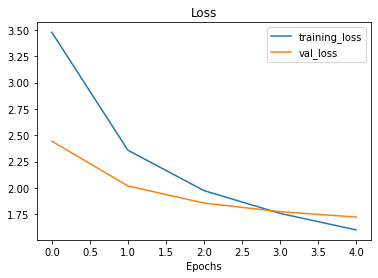

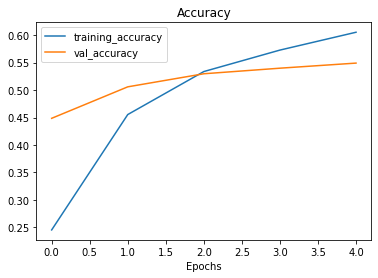

In [79]:
plot_loss_curves(hist)

#fine tuneing

In [80]:
# unfreaze layers
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False
  

In [81]:
model.compile(loss= "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy'])

In [82]:
for layer in base_model.layers :
  print(layer.name, layer.trainable)

input_2 False
rescaling_1 False
normalization_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [83]:
fine_tune_epochs = 10
hist_all_fine_tune= model.fit(train_data_all_10_percent,
                              epochs = fine_tune_epochs,
                              validation_data = test_data,
                              validation_steps = len(test_data),
                              initial_epoch=hist.epoch[-1] )

Epoch 5/10
237/237 [==============================] - 90s 351ms/step - loss: 1.3733 - accuracy: 0.6436 - val_loss: 1.6555 - val_accuracy: 0.5593
Epoch 6/10
237/237 [==============================] - 81s 341ms/step - loss: 1.2383 - accuracy: 0.6766 - val_loss: 1.6450 - val_accuracy: 0.5661
Epoch 7/10
237/237 [==============================] - 80s 339ms/step - loss: 1.1520 - accuracy: 0.6952 - val_loss: 1.6288 - val_accuracy: 0.5697
Epoch 8/10
237/237 [==============================] - 81s 341ms/step - loss: 1.0778 - accuracy: 0.7142 - val_loss: 1.6162 - val_accuracy: 0.5731
Epoch 9/10
237/237 [==============================] - 81s 342ms/step - loss: 1.0230 - accuracy: 0.7213 - val_loss: 1.6209 - val_accuracy: 0.5726
Epoch 10/10
237/237 [==============================] - 81s 340ms/step - loss: 0.9589 - accuracy: 0.7399 - val_loss: 1.6213 - val_accuracy: 0.5743


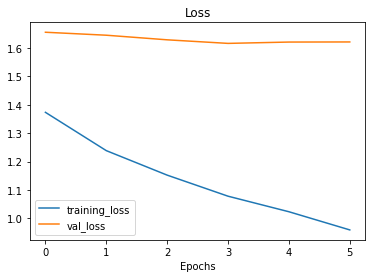

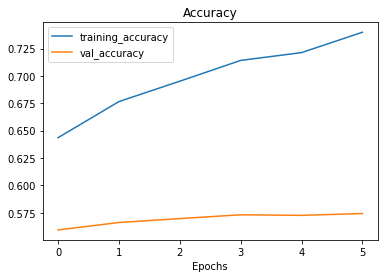

In [84]:
plot_loss_curves(hist_all_fine_tune)

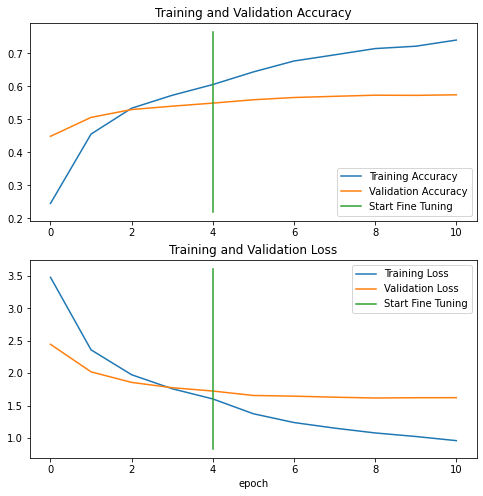

In [85]:
compare_historys(original_history=hist,new_history=hist_all_fine_tune)

In [86]:
model.save("/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent/assets


In [87]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent")

In [88]:
loaded_model_evaluate=loaded_model.evaluate(test_data)
loaded_model_evaluate

790/790 [==============================] - 68s 84ms/step - loss: 1.6213 - accuracy: 0.5743


[1.6213042736053467, 0.5742574334144592]

# downloading a pretraied model 

In [89]:
import tensorflow as tf

In [90]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

--2021-08-08 13:13:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.128, 64.233.182.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   154MB/s    in 0.3s    

2021-08-08 13:13:31 (154 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [91]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [92]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 68s 84ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027207851409912, 0.6077623963356018]

In [93]:
pred_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 53s 66ms/step


In [94]:
len(pred_probs)

25250

In [95]:
pred_probs.shape

(25250, 101)

In [96]:
pred_probs[0]

array([5.9542134e-02, 3.5742110e-06, 4.1376989e-02, 1.0660594e-09,
       8.1614573e-09, 8.6639469e-09, 8.0927026e-07, 8.5652727e-07,
       1.9859068e-05, 8.0977821e-07, 3.1727796e-09, 9.8673718e-07,
       2.8532225e-04, 7.8048884e-10, 7.4230251e-04, 3.8916369e-05,
       6.4740229e-06, 2.4977251e-06, 3.7891088e-05, 2.0678401e-07,
       1.5538462e-05, 8.1507005e-07, 2.6230512e-06, 2.0010719e-07,
       8.3827507e-07, 5.4215920e-06, 3.7391094e-06, 1.3150555e-08,
       2.7761490e-03, 2.8051913e-05, 6.8562661e-10, 2.5574802e-05,
       1.6688893e-04, 7.6406981e-10, 4.0452849e-04, 1.3150681e-08,
       1.7957424e-06, 1.4448199e-06, 2.3062952e-02, 8.2466835e-07,
       8.5365667e-07, 1.7138624e-06, 7.0525148e-06, 1.8402163e-08,
       2.8553370e-07, 7.9483289e-06, 2.0681648e-06, 1.8525219e-07,
       3.3619635e-08, 3.1522560e-04, 1.0410960e-05, 8.5448096e-07,
       8.4741843e-01, 1.0555463e-05, 4.4094864e-07, 3.7404097e-05,
       3.5306119e-05, 3.2489061e-05, 6.7314468e-05, 1.2852564e

In [97]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542134e-02 3.5742110e-06 4.1376989e-02 1.0660594e-09 8.1614573e-09
 8.6639469e-09 8.0927026e-07 8.5652727e-07 1.9859068e-05 8.0977821e-07
 3.1727796e-09 9.8673718e-07 2.8532225e-04 7.8048884e-10 7.4230251e-04
 3.8916369e-05 6.4740229e-06 2.4977251e-06 3.7891088e-05 2.0678401e-07
 1.5538462e-05 8.1507005e-07 2.6230512e-06 2.0010719e-07 8.3827507e-07
 5.4215920e-06 3.7391094e-06 1.3150555e-08 2.7761490e-03 2.8051913e-05
 6.8562661e-10 2.5574802e-05 1.6688893e-04 7.6406981e-10 4.0452849e-04
 1.3150681e-08 1.7957424e-06 1.4448199e-06 2.3062952e-02 8.2466835e-07
 8.5365667e-07 1.7138624e-06 7.0525148e-06 1.8402163e-08 2.8553370e-07
 7.9483289e-06 2.0681648e-06 1.8525219e-07 3.3619635e-08 3.1522560e-04
 1.0410960e-05 8.5448096e-07 8.4741843e-01 1.0555463e-05 4.4094864e-07
 3.7404097e-05 3.5306119e-05 3.2489061e-05 6.7314468e-05 1.2852564e-08
 2.6219754e-10 1.0318126e-05 8.5744177e-05 1.

In [98]:
test_data.class_names[52]

'gyoza'

In [99]:
pred_classes = pred_probs.argmax(axis=1)

In [100]:
pred_classes.shape

(25250,)

In [101]:
for i in pred_classes:
  test_data.class_names[i]

In [102]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [103]:
# unravel test data 
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [104]:
len(y_labels)

25250

In [105]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6077623762376237

In [106]:
from helper_functions import make_confusion_matrix

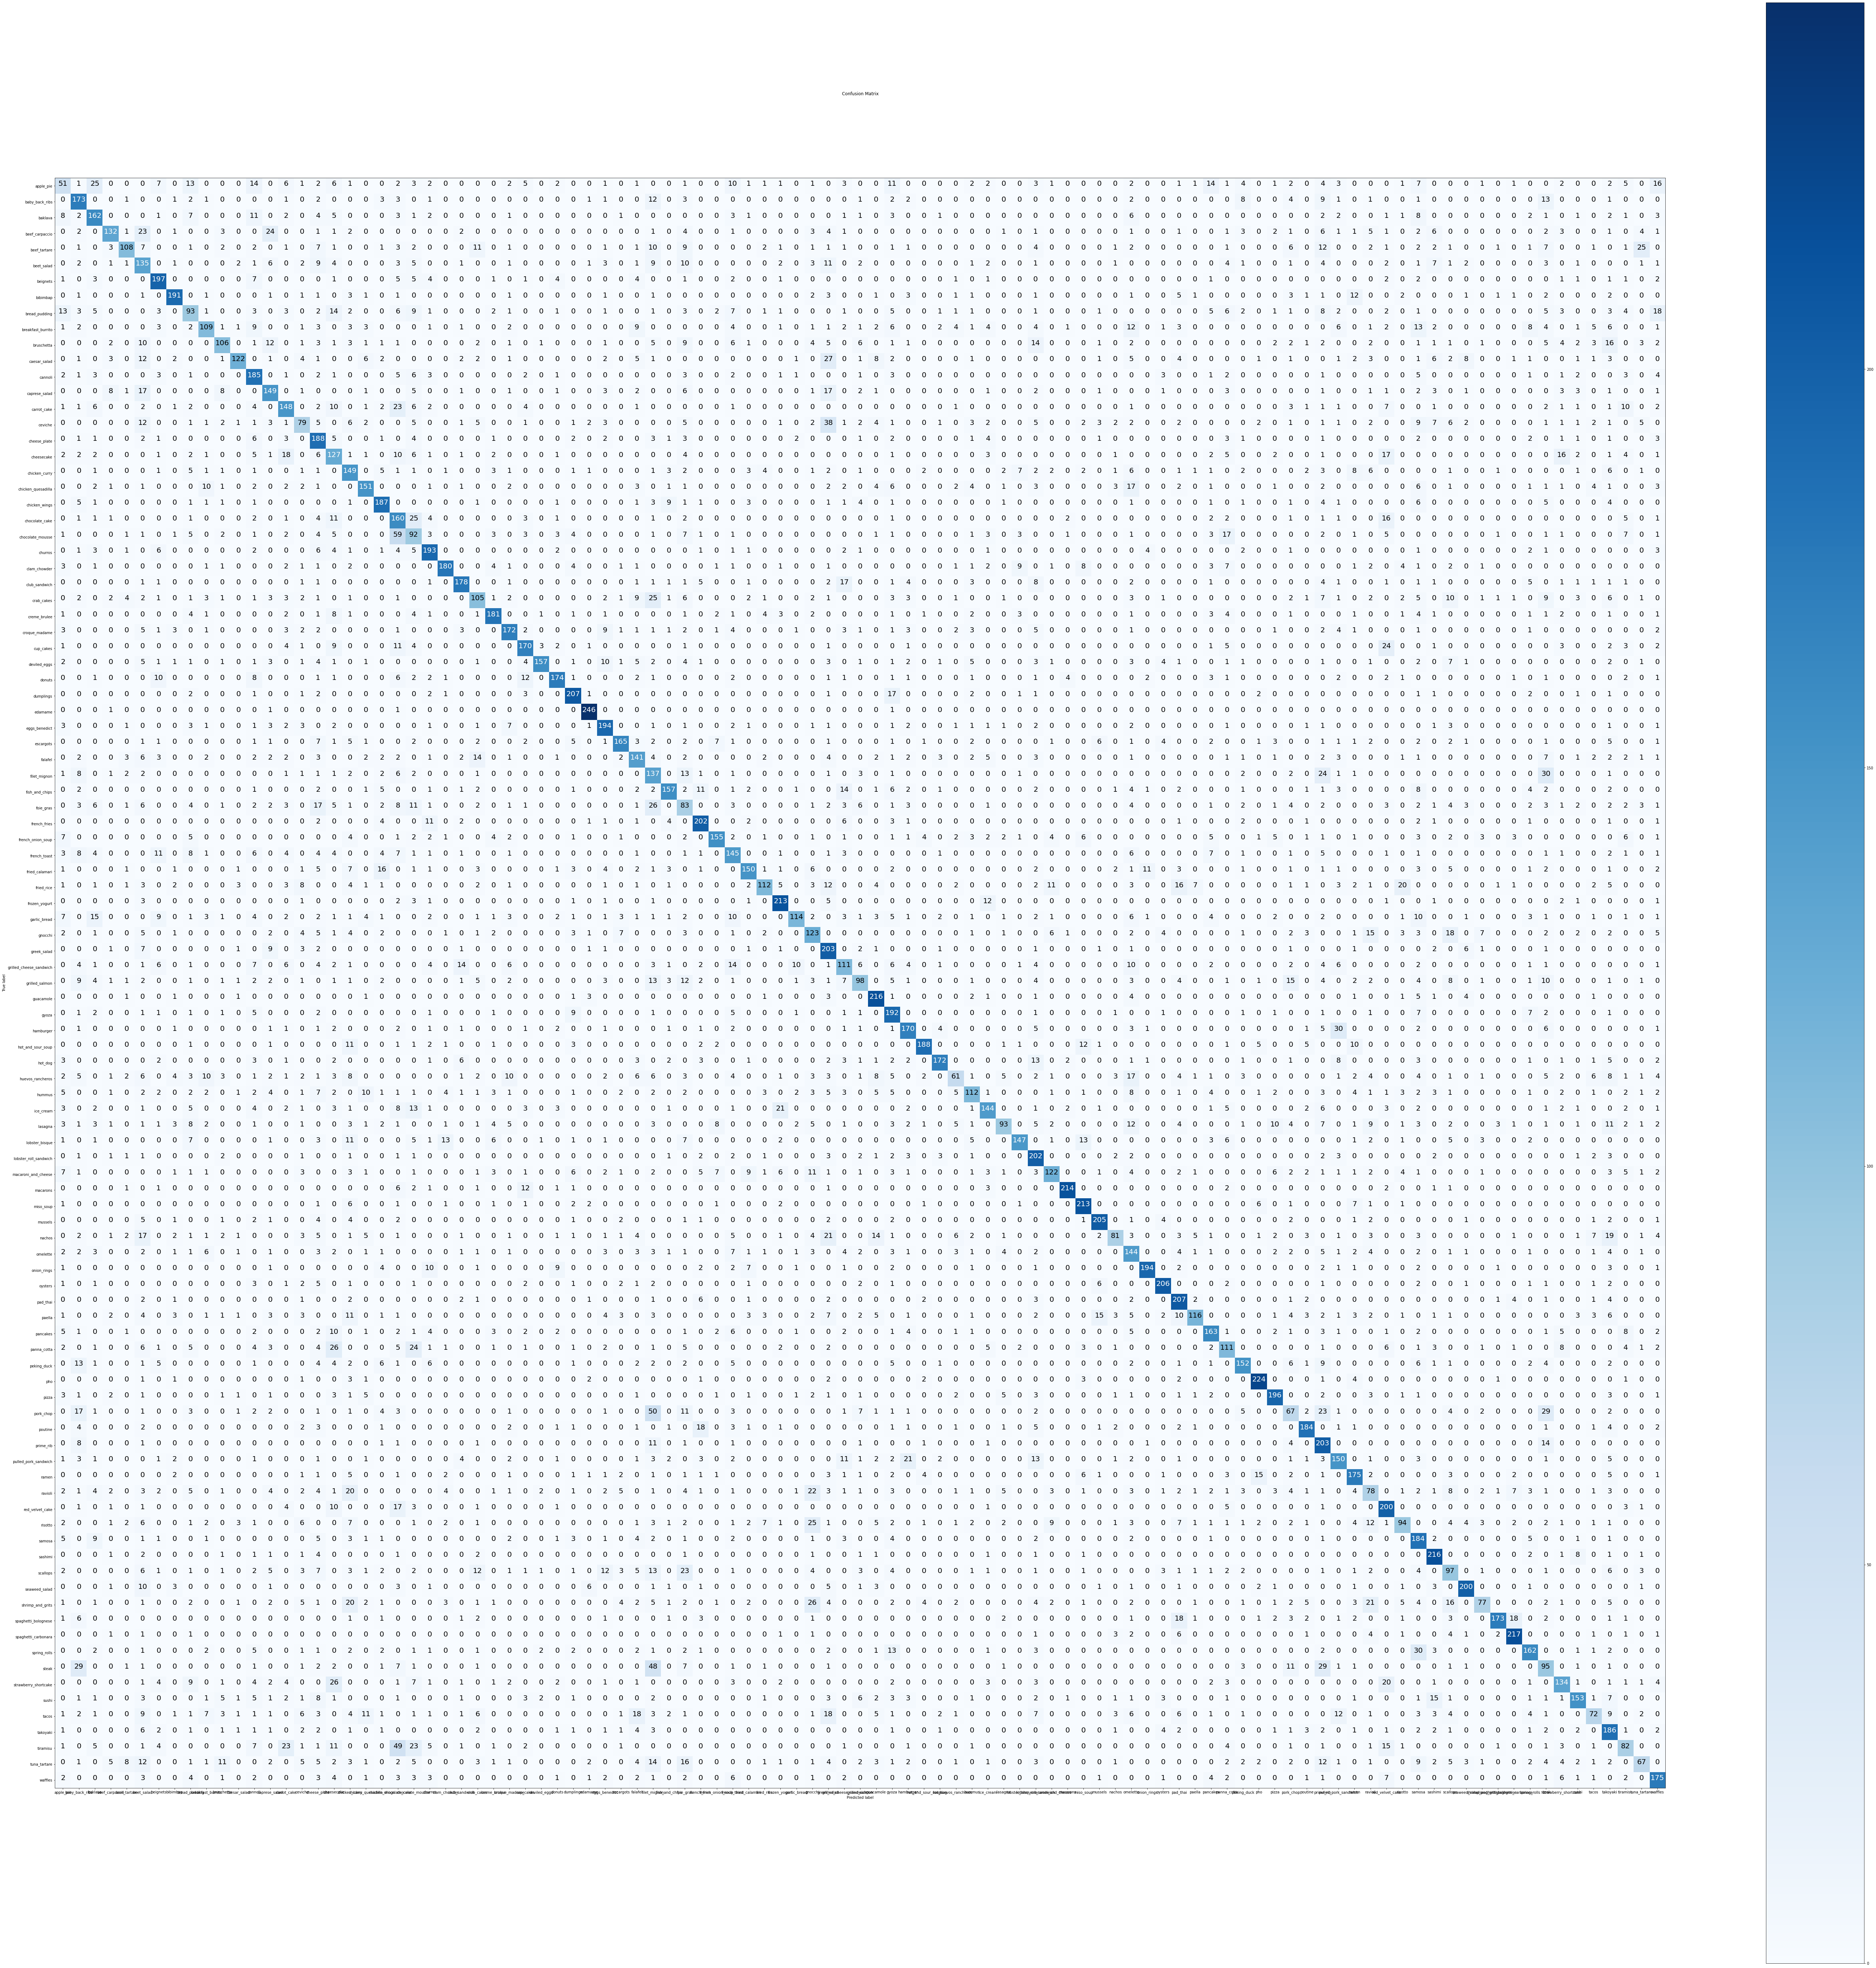

In [107]:
class_names = test_data.class_names
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [108]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [111]:
import pandas as pd
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
print(classification_report_dict)


{'0': {'precision': 0.29310344827586204, 'recall': 0.204, 'f1-score': 0.24056603773584903, 'support': 250}, '1': {'precision': 0.5088235294117647, 'recall': 0.692, 'f1-score': 0.5864406779661017, 'support': 250}, '2': {'precision': 0.5625, 'recall': 0.648, 'f1-score': 0.6022304832713754, 'support': 250}, '3': {'precision': 0.7415730337078652, 'recall': 0.528, 'f1-score': 0.616822429906542, 'support': 250}, '4': {'precision': 0.7346938775510204, 'recall': 0.432, 'f1-score': 0.544080604534005, 'support': 250}, '5': {'precision': 0.34177215189873417, 'recall': 0.54, 'f1-score': 0.41860465116279066, 'support': 250}, '6': {'precision': 0.6677966101694915, 'recall': 0.788, 'f1-score': 0.7229357798165138, 'support': 250}, '7': {'precision': 0.8197424892703863, 'recall': 0.764, 'f1-score': 0.7908902691511386, 'support': 250}, '8': {'precision': 0.4025974025974026, 'recall': 0.372, 'f1-score': 0.3866943866943867, 'support': 250}, '9': {'precision': 0.6193181818181818, 'recall': 0.436, 'f1-score

In [112]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [113]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


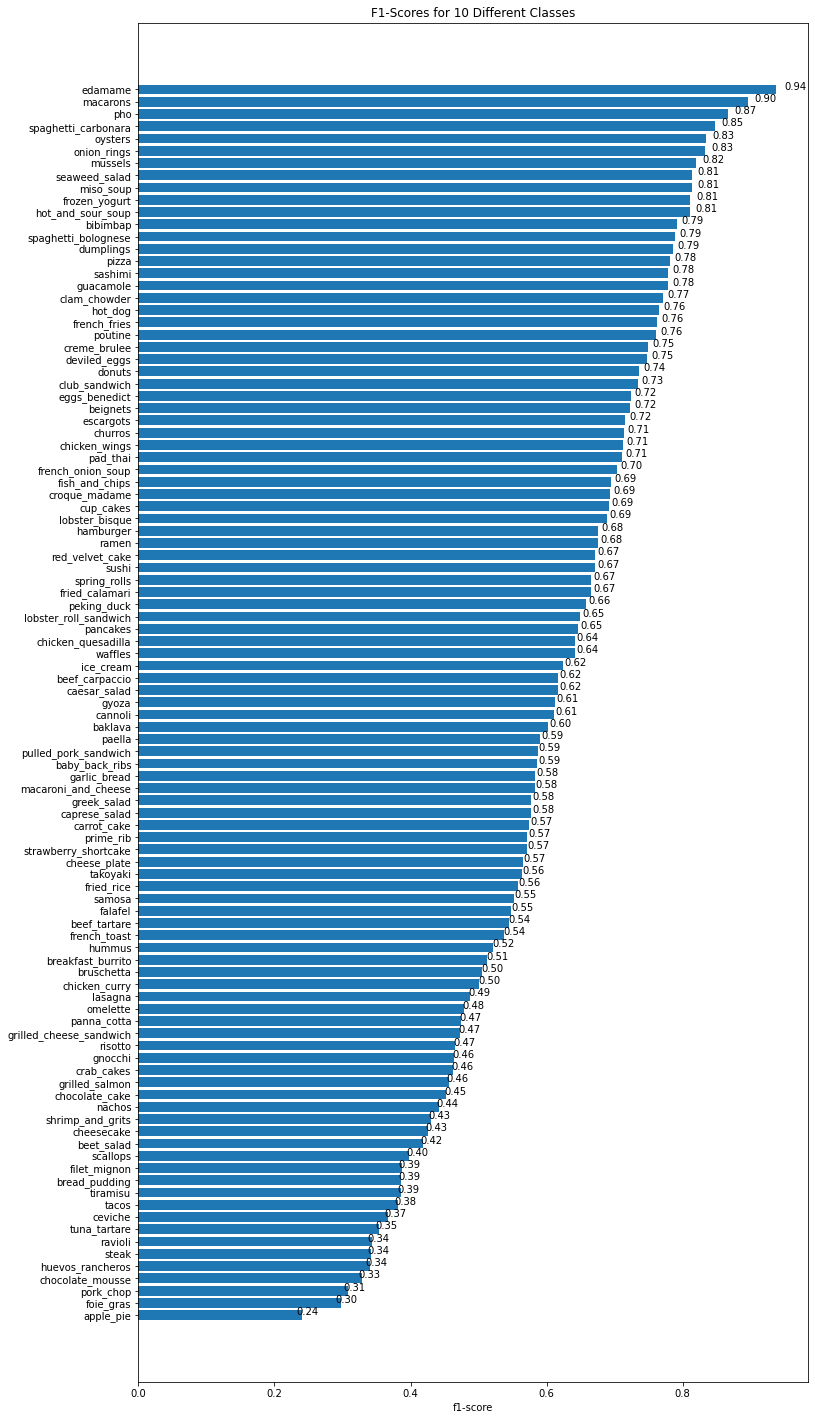

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); 

def autolabel(rects): 
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

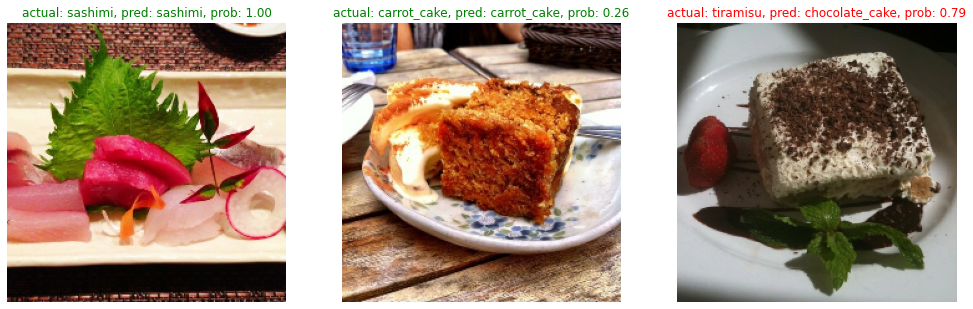

In [122]:
import os
import random
from helper_functions import load_and_prep_image
plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);